In [278]:
import sqlalchemy
import pandas as pd
import numpy as np

import mplfinance as mpf
import utils.ta_lib_indicators as ti

import ipywidgets as widgets
import talib


In [279]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['Indicators', 'MARA_1_Day_Candles', 'MARA_1_Min_Candles', 'MARA_Info', 'RIOT_1_Day_Candles', 'RIOT_1_Min_Candles', 'RIOT_Info', 'TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Info', 'WHD_1_Day_Candles', 'WHD_1_Min_Candles', 'WHD_Info']


In [280]:
# Update table names by looking at the list created above
# MSFT was used to create the example, replace it with the symbol you used
stock_ticker = 'MARA'
daily_df = pd.read_sql_table(
    stock_ticker + '_1_Day_Candles', 
    con=engine, 
    index_col='Datetime',
    )
minutely_df = pd.read_sql_table(
    stock_ticker + '_1_Min_Candles', 
    con=engine, 
    index_col='Datetime'
    )

In [281]:
# print(daily_df.tail())

In [282]:
# print(minutely_df.tail())

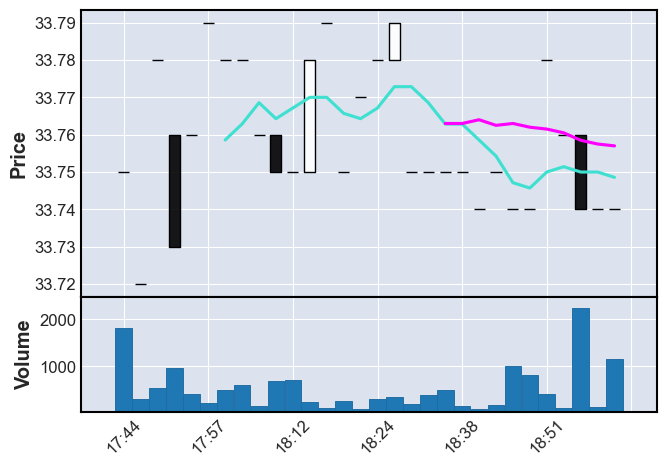

In [283]:
minutely_slice = minutely_df.iloc[-30:]
minutely_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    minutely_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [284]:
pattern_list = []
pattern_df = pd.DataFrame(list(ti.pattern_recognition.items()), columns=['Index', 'Pattern'])
pattern_df = pattern_df.set_index('Index')
# print(pattern_df)
for pattern, p_name in ti.pattern_recognition.items():
    pattern_list.append(pattern)

In [285]:
df = minutely_df.copy()




In [286]:
sel = widgets.SelectMultiple(
        options=pattern_df['Pattern'],
        value=['Doji'],
        rows=min(25, len(pattern_list)),
        description='Candle Pattern:'
    )


In [287]:
output = widgets.Output()

In [288]:
button_submit = widgets.Button(
    description='Submit',
    disabled=False,
    )

In [289]:
display(sel, button_submit, output)
with output:
    print(list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index))

SelectMultiple(description='Candle Pattern:', index=(15,), options=('Two Crows', 'Three Black Crows', 'Three I…

Button(description='Submit', style=ButtonStyle())

Output()

In [290]:

def show_df(b):
    df = minutely_df.copy()
    output.clear_output()
    sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
    for pattern in sel_pattern_list:
        pattern_function = getattr(talib, pattern)
        try:
            result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
            df[pattern] = result
        except Exception as e:
            print(f"{type(e)} Exception! {e}")
    # print(df.head())
    # return df
    with output:
        print(f"{sel_pattern_list}")
        print(df.head())
    # return sel_pattern_list


button_submit.on_click(show_df)



In [291]:
# df = minutely_df.copy()
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())


                      Open   High    Low  Close  Volume  CDLDOJI
Datetime                                                        
2021-09-02 15:54:00  42.49  42.49  42.49  42.49     497        0
2021-09-02 15:57:00  42.50  42.50  42.50  42.50    3125        0
2021-09-02 15:58:00  42.47  42.47  42.47  42.47    1708        0
2021-09-02 16:00:00  42.50  42.50  42.50  42.50    1116        0
2021-09-02 16:01:00  42.55  42.55  42.55  42.55     480        0


In [292]:
len(sel_pattern_list)
df['Sum Patterns'] = df.iloc[:, -(len(sel_pattern_list)):].sum(axis=1)
# df.drop(columns=sel_pattern_list, inplace=True)


In [293]:
atr_function = getattr(talib, 'ATR')

atr_result = atr_function(df['High'], df['Low'], df['Close'], timeperiod=14)

atr_factor = 2.5

df['Trailing Stop'] = df['Close'] - (atr_result * atr_factor)



In [294]:
df['Trade Signal'] = 0.0

threshold_value = 0.0

def check_sum_value(sum_value):
    if sum_value > threshold_value:
        return 1
    elif sum_value < -threshold_value:
        return -1
    else:
        return 0.0

df['Trade Signal'] = df['Sum Patterns'].apply(lambda x: check_sum_value(x))
df.drop(columns='Sum Patterns', inplace=True)
       

In [295]:
df['Pct Change'] = df['Close'].pct_change()


In [296]:
df['Stop Loss'] = np.where(df['Trade Signal']==1,df['Trailing Stop'],0.0)

In [297]:
print(df.iloc[:, -4:].tail(20))
print(df['Trade Signal'].value_counts())

                     Trailing Stop  Trade Signal  Pct Change  Stop Loss
Datetime                                                               
2021-10-01 18:12:00      33.683989           1.0    0.000000  33.683989
2021-10-01 18:13:00      33.713347           0.0    0.000889   0.000000
2021-10-01 18:18:00      33.726322           1.0    0.000296  33.726322
2021-10-01 18:22:00      33.683728           1.0   -0.001184  33.683728
2021-10-01 18:23:00      33.704890           1.0    0.000593  33.704890
2021-10-01 18:24:00      33.717755           1.0    0.000296  33.717755
2021-10-01 18:25:00      33.730416           0.0    0.000296   0.000000
2021-10-01 18:34:00      33.687529           1.0   -0.001184  33.687529
2021-10-01 18:35:00      33.691991           1.0    0.000000  33.691991
2021-10-01 18:37:00      33.696134           1.0    0.000000  33.696134
2021-10-01 18:38:00      33.699982           1.0    0.000000  33.699982
2021-10-01 18:39:00      33.691769           1.0   -0.000296  33

In [298]:
# df['Recalculated Stop Loss'] = pd.NA

# for index, row in df.iterrows():
    
#     if row['Initialize Stop Loss'] > 0.0:
#         df.loc[index, 'Recalculated Stop Loss'] = row['Initialize Stop Loss']

#     elif row['Initialize Stop Loss'] > 0.0 or row['Pct Change'] > 0.0:
#         if row['Trailing Stop'] > row['Recalculated Stop Loss'].shift(1):
#             df.loc[index,'Recalculated Stop Loss'] = row['Trailing Stop']
#         else:
#             df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)
    
#     else:
#         df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)

In [299]:
last_stop = 0.0
# df['Recalculated Stop Loss'] = pd.NA
for index, row in df.iterrows():
    if row['Pct Change'] > 0.0 and row['Trailing Stop'] > last_stop:
        df.loc[index,'Stop Loss'] = row['Trailing Stop']
    else:
        df.loc[index,'Stop Loss'] = last_stop

    last_stop = row['Stop Loss']


In [300]:
print(df.iloc[:, -5:].head(20))

                     CDLDOJI  Trailing Stop  Trade Signal  Pct Change  \
Datetime                                                                
2021-09-02 15:54:00        0            NaN           0.0         NaN   
2021-09-02 15:57:00        0            NaN           0.0    0.000235   
2021-09-02 15:58:00        0            NaN           0.0   -0.000706   
2021-09-02 16:00:00        0            NaN           0.0    0.000706   
2021-09-02 16:01:00        0            NaN           0.0    0.001176   
2021-09-02 16:06:00        0            NaN           0.0    0.001175   
2021-09-02 16:13:00        0            NaN           0.0    0.000000   
2021-09-02 16:14:00        0            NaN           0.0    0.000000   
2021-09-02 16:15:00        0            NaN           0.0    0.000235   
2021-09-02 16:20:00        0            NaN           0.0   -0.000235   
2021-09-02 16:25:00      100            NaN           1.0   -0.001878   
2021-09-02 16:30:00      100            NaN        

In [301]:
df.dropna().to_sql('Indicators', con=engine, if_exists='replace')